Because the original dataset is very big only 2 shapshots have been shown in 
this code so that the code doesnt run for too long.

**It will take a couple of minutes for the code to execute so please be patient**

In [31]:
import networkx as nx
import matplotlib.pyplot as plt
import math
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

In [42]:
#reading the edges from the txt file of dataset

x = 1252
mx = 1e14
ll = []
with open('CollegeMsg.txt') as f:
    lines = f.readlines()
    for line in lines:
      line = line[:-2]
      l = []
      s = ''
      for word in line:
        if word == ' ':
          l.append(int(s))
          s = ''
        else:
          s += word
      l.append(int(s))
      l[2] = (l[2])//86400 - x
      ll.append(l)
      mx = min(mx, l[2])

In [60]:
lll = []

for l in ll:
  if l[2] <= 5 and l[2] >= 3:
    lll.append(l)

l = lll

In [64]:
#nodes of different timestamps are separated and stored as a list of networkx components

G = {}
edge_list = []

last = 0

for node in l:
  if node[2] > 5:
    break
  if node[2] != last:
    G[node[2]-1] = nx.Graph()
    edge_list = edge_list[:min(len(edge_list), 50)]
    G[node[2]-1].add_edges_from(edge_list)
    edge_list = []
  else:
    #print(node[2])
    edge_list.append((int(node[0]), int(node[1])))
  last = node[2]

G[last] = nx.Graph()
edge_list = edge_list[:min(len(edge_list), 50)]
G[last].add_edges_from(edge_list)

In [65]:
#each unit of time in our dataset is the time duration of 1 day
#the complete dataset has a total of 20 timestamps worth of edges 
#that is reduced to only 5 timestamps worth of data otherwise the code runs for too long

G

{2: <networkx.classes.graph.Graph at 0x7fba462a0310>,
 3: <networkx.classes.graph.Graph at 0x7fba462ba150>,
 4: <networkx.classes.graph.Graph at 0x7fba462ba590>,
 5: <networkx.classes.graph.Graph at 0x7fba46c02390>}

In [37]:
max(G[1].nodes())

72

In [38]:
#this list is required for dynamic checking of 

colour = []

In [39]:
def run_simulation(G, times, Prob_R, Prob_S, Prob_I, lamda, gamma, mu, nodes, Adj_matrix):
    temp_Prob_R, temp_Prob_S, temp_Prob_I = Prob_R, Prob_S, Prob_I
    for t in range(1, times+1):
        # calculate Prob_S for every node
        for node in nodes:
            Prob_S[node] = temp_Prob_S[node]
            mult = 1
            for n in nodes:
                #print(n)
                if n in colour and node in colour and colour[node] == colour[n]:
                  gamma = 0.3
                else:
                  gamma = 1
                y = 0
                if (n, node) in Adj_matrix:
                  y = 1
                mult *= (1 - lamda * gamma * y * temp_Prob_I[n])
            Prob_S[node] *= mult
        # calculate Prob_I for every node
        for node in nodes:
            Prob_I[node] = temp_Prob_S[node]
            mult = 1
            for n in nodes:
                if n in colour and node in colour and colour[node] == colour[n]:
                  gamma = 0.3
                else:
                  gamma = 1
                y = 0
                if (n, node) in Adj_matrix:
                  y = 1
                mult *= (lamda * gamma * y * temp_Prob_I[n])
            Prob_I[node] *= (1 - mult)
            Prob_I[node] += (1 - mu) * temp_Prob_I[node]
        # calculate Prob_R for every node
        for node in nodes:
            Prob_R[node] = mu * temp_Prob_I[node] + temp_Prob_R[node]
        temp_Prob_S, temp_Prob_I, temp_Prob_R = Prob_S, Prob_I, Prob_R
    return temp_Prob_S, temp_Prob_I, temp_Prob_R

In [40]:
def dynamic_detection(G, colour, xx):
  #print("GRAPH BEFORE PARTITION")
  ax = plt.gca()
  ax.set_title("GRAPH BEFORE PARTITION FOR SNAPSHOT AT TIME = {}".format(xx))
  plt.figure(figsize = (20, 10))
  plt.subplot(122)
  nx.draw(G, with_labels=True, font_weight='bold', ax=ax)
  #Adj_matrix = nx.adjacency_matrix(G).todense().tolist()
  Adj_matrix = []

  for n1 in list(G.nodes()):
    for n2 in list(G.nodes()):
      if n1 == n2:
        continue
      Adj_matrix.append((n1, n2))

  #print("Adj formed")
  ntimes = 5
  lamda = 0.9
  mu = 0.8
  gamma = 1
  nodes = list(G.nodes())

  mxnd = max(G.nodes())

  for i in range(len(nodes)):
    nodes[i] = nodes[i] - 1

  Prob_vec = [[0 for i in range(mxnd)] for j in range(mxnd)]
  #print("Starting loop")
  for node in nodes:
      #print(node)
      Prob_R = [0 for _ in range(mxnd)]
      Prob_S = [mu for _ in range(mxnd)]
      Prob_I = [0 for _ in range(mxnd)]
      
      Prob_I[node] = 1
      #print("starting")
      Prob_S, Prob_I, Prob_R = run_simulation(G, ntimes, Prob_R, Prob_S, Prob_I, lamda, gamma, mu, nodes, Adj_matrix)
      #print("ending")
      for n in nodes:
          Prob_vec[n][node] = Prob_R[n]
  #print("Endling Loop")
  Part_matrix = [[0 for i in range(len(nodes))] for j in range(len(nodes))]
  for i in range(len(nodes)):
      for j in range(len(nodes)):
          if i != j:
              Part_matrix[i][j] = Prob_vec[i][j]
          else:
              x = 0
              for jj in range(len(nodes)):
                  if jj != i:
                      x += Prob_vec[i][jj]
              Part_matrix[i][j] = x / (len(nodes)-1)
  #print("Partition over")
  means = [0 for _ in range(len(nodes))]
  sds = [0 for _ in range(len(nodes))]  
  for i in range(len(nodes)):
      means[i] = sum(Part_matrix[i])/(len(nodes))
  for i in range(len(nodes)):
      x = 0
      for k in range(len(nodes)):
          x += (Part_matrix[i][k] - means[i])*(Part_matrix[i][k] - means[i])
      x /= len(nodes)
      sds[i] = math.sqrt(x)
  #print(sds)
  Pear_cor = [[0 for i in range(len(nodes))] for j in range(len(nodes))]
  for i in range(len(nodes)):
      for j in range(len(nodes)):
          x = 0
          for k in range(len(nodes)):
              x += (Part_matrix[i][k]-means[i])*(Part_matrix[j][k]-means[j])
          aa = len(nodes)
          bb = sds[i]
          cc = sds[j]
          if aa == 0:
            aa = 1
          if bb == 0:
            bb = 1
          if cc == 0:
            cc = 1
          x /= (aa * bb * cc)
          Pear_cor[i][j] = x
  Distance_matrix = [[0 for i in range(len(nodes))] for j in range(len(nodes))]
  for i in range(len(nodes)):
      for j in range(len(nodes)):
          Distance_matrix[i][j] = 1 - Pear_cor[i][j]
  cluster = AgglomerativeClustering(n_clusters=15, affinity='precomputed', linkage='single')
  cluster.fit(Distance_matrix)
  colors = cluster.labels_
  colour = colors
  #print(colors)
  #print("GRAPH AFTER PARTITION")
  ax = plt.gca()
  ax.set_title("GRAPH AFTER PARTITION FOR SNAPSHOT AT TIME={}".format(xx))
  plt.figure(figsize = (20, 10))
  plt.subplot(122)
  nx.draw(G, with_labels=True, font_weight='bold', node_color=colors, ax=ax)
  return colour

interation {} 3
interation {} 4


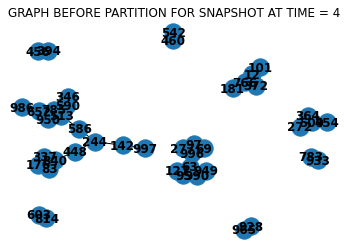

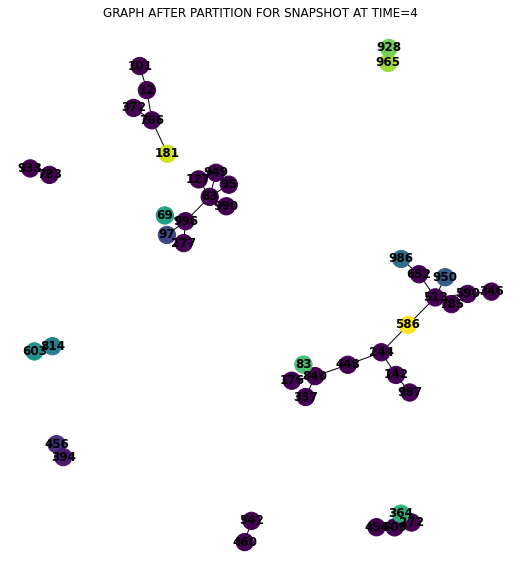

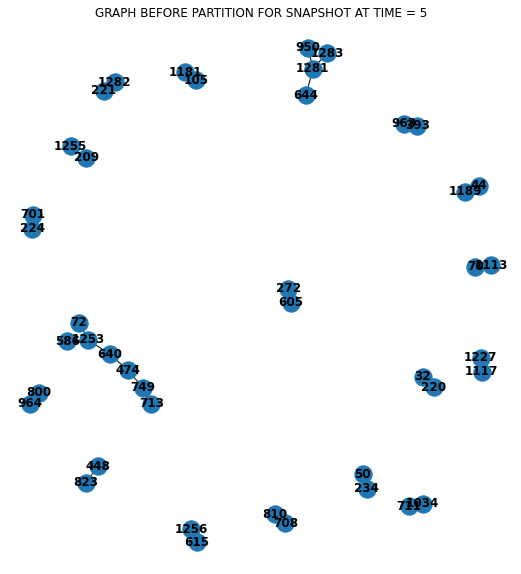

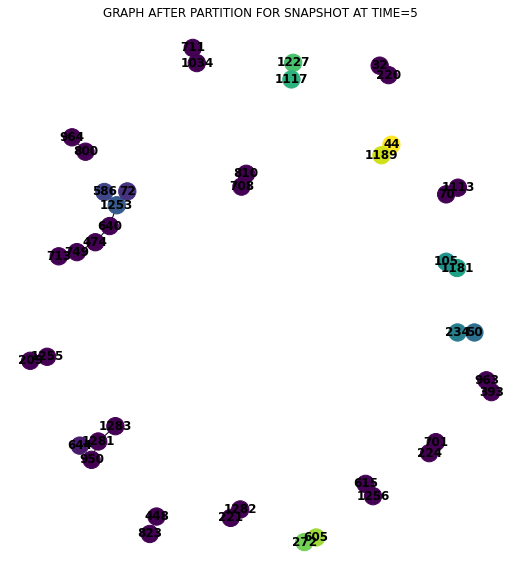

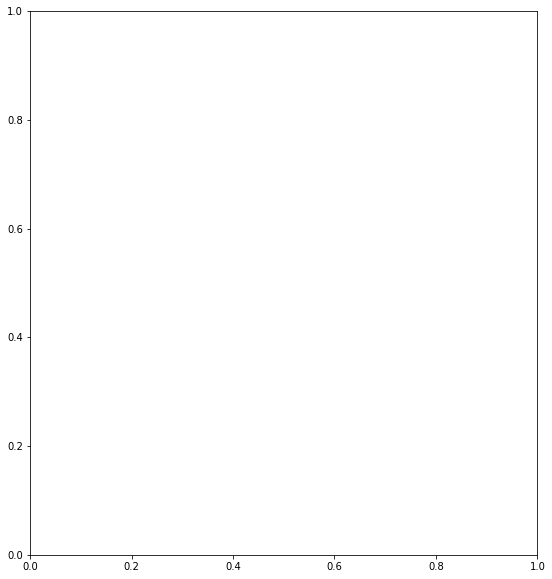

In [75]:
#colour = dynamic_detection(G[2], colour)
col = []
for i in range(3, 5):
  print("interation {}",format(i))
  #print("Iteration Number {}".format(i+1))
  colour = dynamic_detection(G[i], colour, i+1)
  col.append(colour)

In [69]:
for c in col:
  print(len(c))

44
43
69


In [78]:
count = 0

for i in range(1, 2):
  count = 0
  n = len(G[i+3].edges())
  s = (n*(n+1))/2
  for e1 in range(len(G[i+3].edges())):
    for e2 in range(e1+1, len(G[i+3].edges())):
      if e1 >= len(col[i-1]) or e2 >= len(col[i-1]) or e1 >= len(col[i]) or e2 >= len(col[i]):
        continue;
      if col[i][e1] == col[i][e2] and col[i-1][e1] == col[i-1][e2]:
        count = count + 1
  print("Simmilarity between snapshot {} and snapshot {}".format(i, i+1))
  print("{}%".format((count/s)*100))

Simmilarity between snapshot 1 and snapshot 2
92.3076923076923%
